<a href="https://colab.research.google.com/github/Crowbar97/MetropolisHastingsSampling/blob/master/MHAlgorithm2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.special import gamma
from scipy import optimize, integrate
from operator import add
from math import sqrt, pi, exp, log2
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

In [0]:
class Distribs:
    class Normal:
        def __init__(self, mean, var):
            self.mean = mean
            self.var = var

        def set_mean(self, mean):
            self.mean = mean

        def set_var(self, var):
            self.var = var

        # probability density function
        def pdf(self, x):
            return 1 / sqrt(2 * pi * self.var ** 2) \
                   * exp(- (x - self.mean) ** 2 / (2 * self.var ** 2))

        # random variates
        def rvs(self, count=1):
            v = np.random.normal(self.mean, self.var, int(count))
            if count == 1:
                return v[0]
            return v
    
    class Uniform:
        def __init__(self, a, b):
            self.a = a
            self.b = b

        def pdf(self, x):
            if self.a <= x <= self.b:
                return 1 / (self.b - self.a)
            return 0

        def rvs(self, count=1):
            v = np.random.uniform(self.a, self.b, int(count))
            if count == 1:
                return v[0]
            return v

    class NormalMixture:
        def __init__(self, mu):
            self.mu = mu

        def pdf(self, x):
          return 1 / (2 * sqrt(2 * pi)) * (exp(-(x - self.mu) ** 2 / 2)
                 + exp(-(x + self.mu) ** 2 / 2))

In [0]:
class Plotter:
    @staticmethod
    def plot(funs, bounds):
        left_bound, right_bound, step = bounds
        x = np.arange(left_bound, right_bound, step)
        
        plt.figure()
        colors = ['g', 'b', 'r']
        for i in range(len(funs)):
            y = list(map(funs[i][0], x))
            plt.plot(x, y, colors[i % len(colors)] + 'o-', label=funs[i][1])

        plt.xlabel("x", fontsize=20)
        plt.ylabel("y", fontsize=20)
        plt.grid(True)
        plt.legend(loc=0, fontsize=20)

        plt.show()
        pass

    @staticmethod
    def compare(dist, samples,
                var, bins=200,
                left_bound=-10, right_bound=10, step=0.1):
        linspace = np.arange(left_bound, right_bound, step)

        plt.plot(linspace,
                 np.array(list(map(dist.pdf, linspace))),
                 'go-', label="Target density")

        plt.hist(samples, bins=bins, density=True, label="Samples")

        plt.title("Proposal distribution variance = %.1f" % var,
                  fontsize=20)
        
        plt.xlabel("x", fontsize=20)
        plt.ylabel("y", fontsize=20)
        plt.grid(True)
        plt.legend(loc=0, fontsize=20)

        plt.show()

In [0]:
class MHSampler:
    @staticmethod
    def metropolis_ratio(target_dist, x0, x1):
        return target_dist.pdf(x1) / target_dist.pdf(x0)

    @staticmethod
    def hastings_ratio(prop_dist, x0, x1):
        prop_dist.set_mean(x0)
        q0 = prop_dist.pdf(x1)

        prop_dist.set_mean(x1)
        q1 = prop_dist.pdf(x0)

        prop_dist.set_mean(x0)

        return q1 / q0

    @staticmethod
    def accepted(accept_prob):
        return np.random.binomial(1, min(accept_prob, 1), 1)[0]

    @staticmethod
    def discard(samples, disc_part):
        del samples[:int(len(samples) * disc_part)]

    @staticmethod
    def sample(target_dist, prop_dist, x_init=0,
               sample_count=1e5, disc_part=0.1):
        x0 = x_init
        target_samples = [x0]
        sample_count -= 1
        while(sample_count):
            prop_dist.set_mean(x0)

            x1 = prop_dist.rvs()

            accept_prob = MHSampler.metropolis_ratio(target_dist, x0, x1) \
                          * MHSampler.hastings_ratio(prop_dist, x0, x1)

            if MHSampler.accepted(accept_prob):
                target_samples.append(x0)
                x0 = x1
                sample_count -= 1

        MHSampler.discard(target_samples, disc_part)
        prop_dist.set_mean(x_init)

        return target_samples


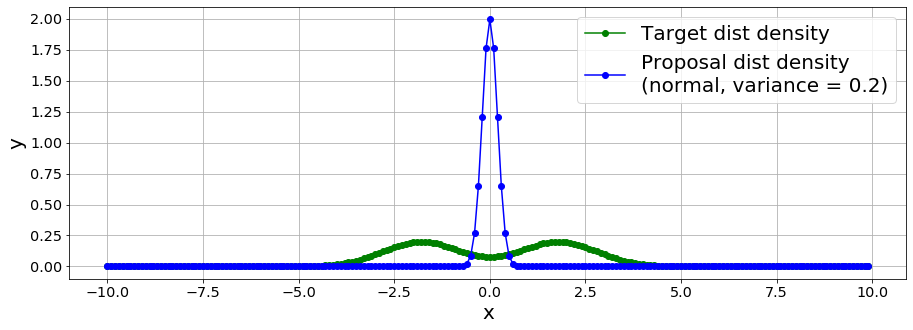

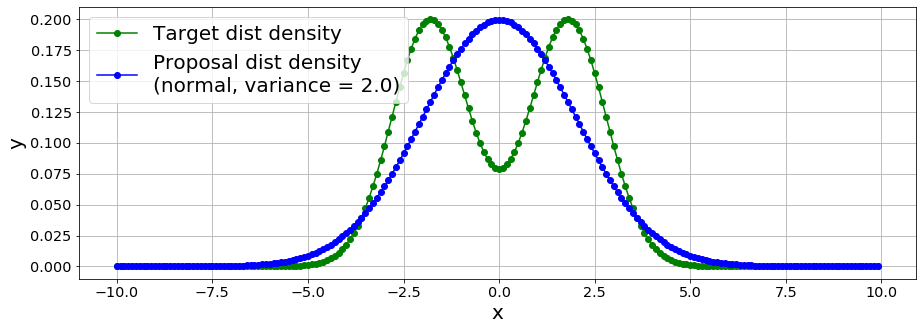

In [12]:
# target distribution
target_dist = Distribs.NormalMixture(1.8)

# proposal (approximating) distribution
var = 0.2
prop_dist = Distribs.Normal(0, var)
Plotter.plot([(target_dist.pdf,
               "Target dist density"),
              (prop_dist.pdf,
               "Proposal dist density\n(normal, variance = %.1f)" % var)],
             (-10, 10, 0.1))

var = 2.0
prop_dist = Distribs.Normal(0, var)
Plotter.plot([(target_dist.pdf,
               "Target dist density"),
              (prop_dist.pdf,
               "Proposal dist density\n(normal, variance = %.1f)" % var)],
             (-10, 10, 0.1))

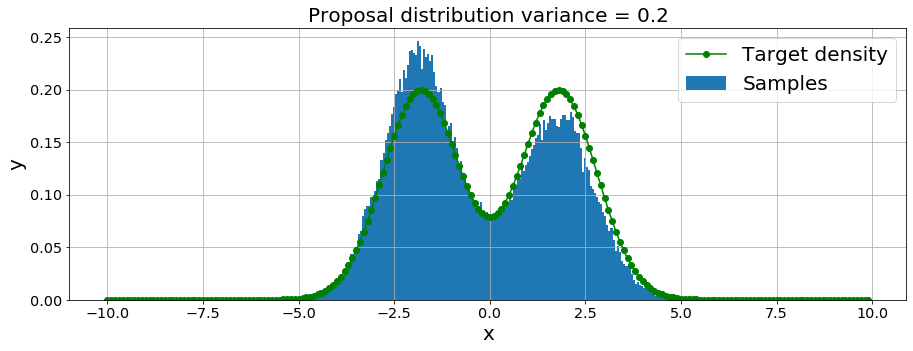

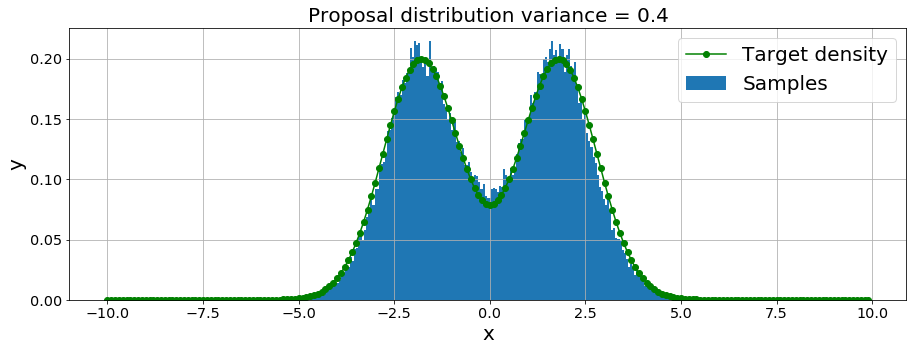

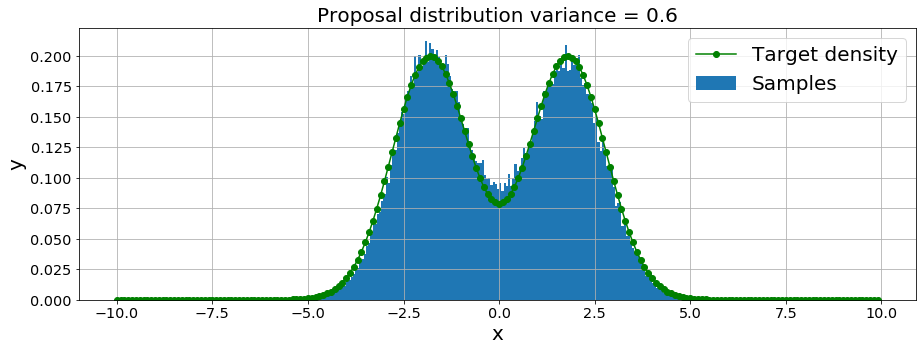

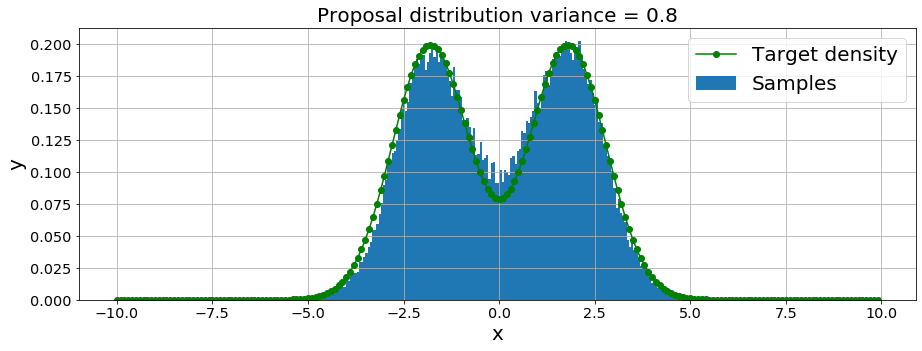

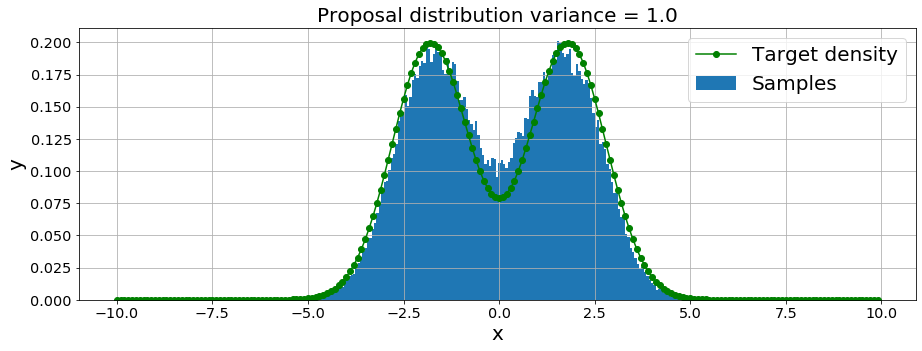

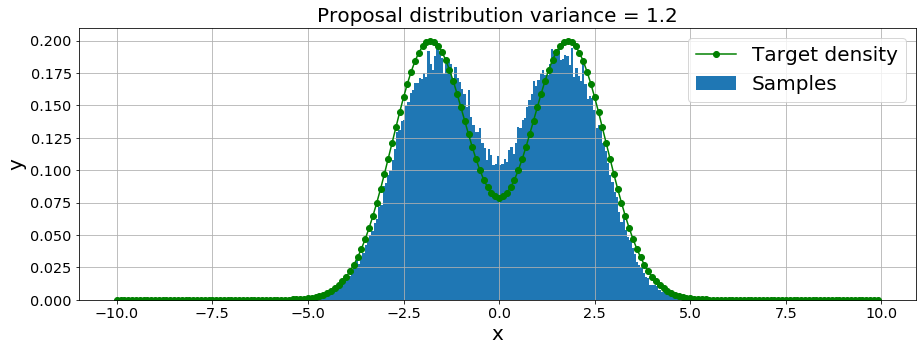

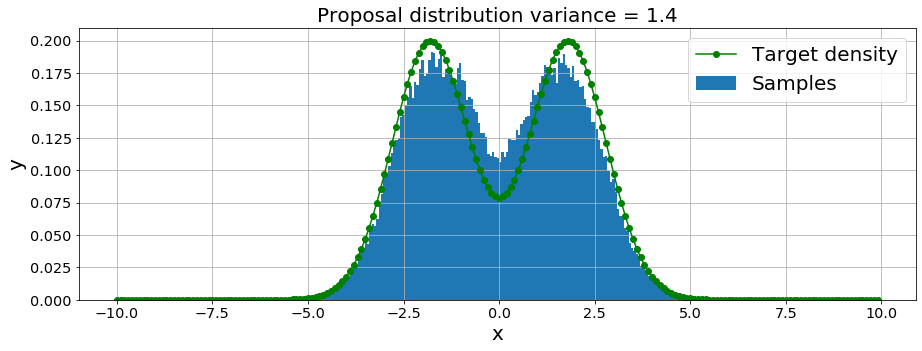

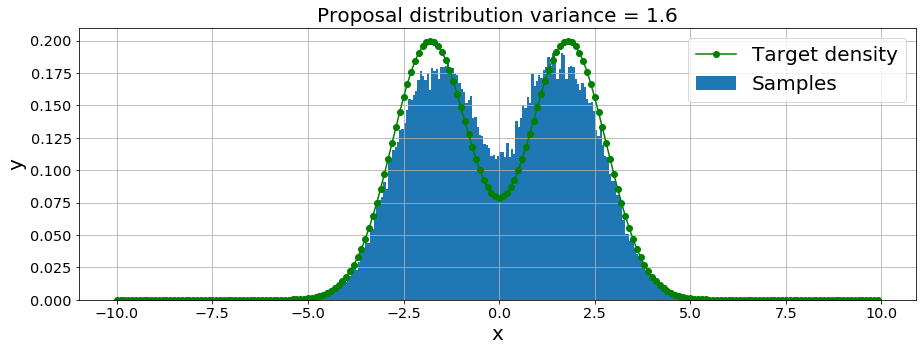

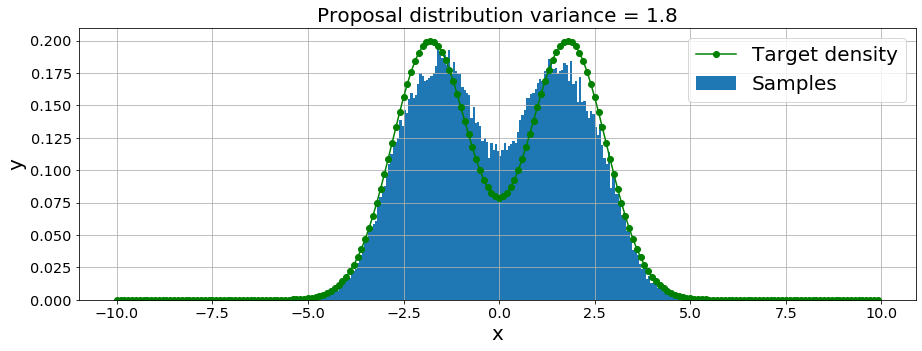

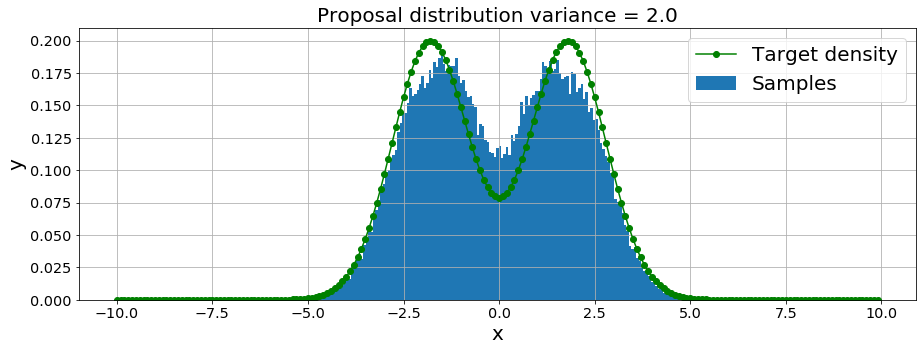

In [15]:
for var in np.arange(0.2, 2.2, 0.2):
    prop_dist = Distribs.Normal(0, var)
    target_samples = MHSampler.sample(target_dist, prop_dist, x_init=0,
                                      sample_count=1e5, disc_part=0.1)
    Plotter.compare(target_dist, target_samples, var=var)